In [2]:
import pandas as pd
import requests
import numpy as np

# 추가 분석 과제

우왁굳님의 최적의 듀오는 누구일까..!
팀운이 많이 적용되는 게임이긴 하지만.. 현재까지 데이터를 기반으로 왁굳님과의  시너지가 좋은 멤버를 통계적으로 확인해보자

* 15분 이상 진행된 미드라이너 경기

In [3]:
def get_puuid(summoner_name, api_key):
    # Get summoner puuid
    sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
    url = sohwan.format(summoner_name, api_key)
    response = requests.get(url)
    puuid = response.json()['puuid']
    summoner_id = response.json()['id']
    iconId = response.json()['profileIconId']

    return puuid, summoner_id, iconId,


def get_match_ids(puuid, api_key, start= 0, count= 50):
    # Get match ids
    matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
    url = matchid_url.format(puuid, start, count, api_key)
    response = requests.get(url)
    match_ids = response.json()
    return match_ids


def get_match_data_logs(match_ids,api_key):
    # Get match data for each match id
    match_data_logs = []
    time_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key={}'
    for i, match_id in enumerate(match_ids):
        url = time_url.format(match_id, api_key)
        response = requests.get(url)
        match_data_logs.append(pd.DataFrame(response.json()))

    return  match_data_logs


summoner_name = '메시아빠우왁굳'
#api_key= 'RGAPI-1d068ec6....'

puuid, summoner_id, iconId = get_puuid(summoner_name, api_key)
match_ids = get_match_ids(puuid, api_key, start= 0, count= 50)
match_data_logs = get_match_data_logs(match_ids, api_key)


In [ ]:
test = pd.concat(match_data_logs)

In [ ]:
test_id = match_ids[:5]

In [4]:
# match_v5 (경기가 끝나고 나오는 통계요약)
def get_match_v5(match_ids, api_key):
    url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'
    match_info_list = []
    champion_info_list = []

    for match_id in match_ids:
        response = requests.get(url.format(match_id, api_key))
        match_df = pd.DataFrame(response.json())

        try:
            df = pd.DataFrame(match_df['info']['participants'])
        except KeyError:
            print(f"KeyError: 'info' key not found in match_df for matchId {match_id}. Skipping...")
            continue

        sample = df[['teamId', 'puuid', 'summonerName', 'participantId', 'teamPosition', 'challenges', 'summoner1Id', 'summoner2Id',
            'championName', 'lane', 'kills', 'deaths', 'assists', 'totalMinionsKilled', 'neutralMinionsKilled', 'goldEarned', 'goldSpent', 'champExperience', 'item0', 'item1', 'item2',
            'item3', 'item4', 'item5', 'item6', 'totalDamageDealt', 'totalDamageDealtToChampions', 'totalDamageTaken', 'damageDealtToTurrets', 'damageDealtToBuildings',
            'totalTimeSpentDead', 'longestTimeSpentLiving', 'visionScore', 'win', 'timePlayed', 'damageSelfMitigated', 'totalDamageShieldedOnTeammates',
            'totalHealsOnTeammates', 'damageDealtToObjectives']]

        challenge = pd.DataFrame(sample['challenges'].tolist())

        col = challenge[['soloKills', 'multikills', 'abilityUses', 'damageTakenOnTeamPercentage', 'skillshotsDodged', 'skillshotsHit', 'enemyChampionImmobilizations', 'laneMinionsFirst10Minutes','controlWardsPlaced'
                        , 'visionScorePerMinute', 'wardTakedowns', 'effectiveHealAndShielding', 'dragonTakedowns', 'baronTakedowns', 'teamBaronKills']]
        jungle_and_etc_col = challenge.filter(regex='^jungle|Jungle|kda')

        match_info = pd.concat([sample, col, jungle_and_etc_col], axis=1)
        match_info['summonerName'] = match_info.apply(lambda row: row['puuid'][:10] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
        match_info['totalCS'] = match_info['totalMinionsKilled'] + match_info['neutralMinionsKilled']
        match_info['matchId'] = match_df['metadata']['matchId']
        match_info['championName'] = match_info['championName'].apply(lambda x: 'Fiddlesticks' if x == 'FiddleSticks' else x)  # 피들스틱 에러

        champion_info = match_info[['win','matchId', 'participantId', 'teamId', 'teamPosition', 'summonerName', 'puuid', 'championName']]

        match_info['win_kr'] = match_info['win'].apply(lambda x: '승리' if x == 1 else '패배')
        match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

        # 각각의 데이터를 리스트에 추가
        match_info_list.append(match_info)
        champion_info_list.append(champion_info)

        match_info = pd.concat(match_info_list)
        champion_info = pd.concat(champion_info_list)

    return match_info, champion_info


match_info, champion_info = get_match_v5(match_ids,api_key)


KeyError: 'info' key not found in match_df for matchId KR_6863866115. Skipping...


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

champion_info['matchId'].nunique()


50

In [ ]:
# 15분 초과의 경기만

def matchId_by_position (match_info, puuid ): # position
  match_info = match_info[(match_info['timePlayed'] > 900) & (match_info['puuid']==puuid) ] # & (match_info['teamPosition'] == position)
  matchId_list = match_info['matchId'].drop_duplicates().tolist()
  return matchId_list

matchId_list = matchId_by_position(match_info,puuid) # 48
match_info = match_info[match_info['matchId'].isin(matchId_list)]



In [ ]:
match_info['ti']

,teamId,puuid,summonerName,participantId,teamPosition,challenges,summoner1Id,summoner2Id,championName,lane,kills,deaths,assists,totalMinionsKilled,neutralMinionsKilled,goldEarned,goldSpent,champExperience,item0,item1,item2,item3,item4,item5,item6,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,damageDealtToTurrets,damageDealtToBuildings,totalTimeSpentDead,longestTimeSpentLiving,visionScore,win,timePlayed,damageSelfMitigated,totalDamageShieldedOnTeammates,totalHealsOnTeammates,damageDealtToObjectives,soloKills,multikills,abilityUses,damageTakenOnTeamPercentage,skillshotsDodged,skillshotsHit,enemyChampionImmobilizations,laneMinionsFirst10Minutes,controlWardsPlaced,visionScorePerMinute,wardTakedowns,effectiveHealAndShielding,dragonTakedowns,baronTakedowns,teamBaronKills,alliedJungleMonsterKills,enemyJungleMonsterKills,epicMonsterKillsNearEnemyJungler,getTakedownsInAllLanesEarlyJungleAsLaner,jungleCsBefore10Minutes,junglerTakedownsNearDamagedEpicMonster,kda,killsOnOtherLanesEarlyJungleAsLaner,moreEnemyJungleThanOpponent,takedownsBeforeJungleMinionSpawn,junglerKillsEarlyJungle,killsOnLanersEarlyJungleAsJungler,totalCS,matchId,win_kr,totalCS10Minutes
0,100,hSZ_GNCXzwhAl7tfk5gyj9HlxysceUJ8nPauPMCyWHaXv1...,분지울,1,TOP,"{'12AssistStreakCount': 0, 'abilityUses': 91, ...",21,4,Warwick,TOP,0,12,5,77,0,7308,8195,11909,3077,3111,6610,1054,1036,0,3340,48016,5462,37618,1937,1937,317,373,18,False,1838,24226,0,0,2851,0,0,91,0.261062,7,0,9,31,1,0.612016,2,0.0,0,1,1,0,0,0,0.0,0.0,0,0.416667,0.0,0.0,0,NaN,NaN,77,KR_6905652615,패배,31.0
1,100,rYBYusOo6mZBaek7Zg_l12gDNuxT1PBSH5m9Agf6xY7Gzv...,환돌이이,2,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 638,...",11,4,Talon,JUNGLE,10,4,4,59,155,16093,16000,16955,6696,3156,3142,3158,6694,3026,3364,256828,25851,32849,0,0,129,782,25,False,1838,22748,0,0,45966,5,1,638,0.227968,15,81,1,13,0,0.828176,6,0.0,2,1,1,52,13,1,NaN,54.0,0,3.500000,NaN,-29.0,0,0.0,2.0,214,KR_6905652615,패배,67.0
2,100,9KSQywyOxFDCx7pd4XFnE7O9LlFfG1kpKKZxh0PvpxSMJk...,충신병자 진드기,3,MIDDLE,"{'12AssistStreakCount': 0, 'abilityUses': 196,...",12,4,Lissandra,MIDDLE,5,8,5,152,4,10477,9425,12878,3118,2420,2055,4645,3020,0,3340,101891,13651,25463,413,413,318,893,20,False,1838,11126,0,0,2719,0,0,196,0.176714,15,32,23,74,0,0.680792,4,0.0,0,1,1,6,0,0,0.0,0.0,0,1.250000,0.0,0.0,0,NaN,NaN,156,KR_6905652615,패배,74.0
3,100,7tW5cFq9Au96KcE1mO-kfVsipVZCm_w8loMA8HcmOXosBX...,모닝전문털이범,4,BOTTOM,"{'12AssistStreakCount': 0, 'abilityUses': 318,...",1,4,Ezreal,BOTTOM,7,8,3,191,0,12896,12383,11812,3158,2015,3086,3036,3042,3078,3363,140809,26491,23676,5502,5502,165,458,14,False,1838,8522,0,0,12029,1,0,318,0.164310,10,86,0,65,0,0.466666,1,0.0,0,1,1,0,0,0,0.0,0.0,0,1.250000,0.0,0.0,0,NaN,NaN,191,KR_6905652615,패배,65.0
4,100,KGWDhY3WkA6EWU0gklon8NjuNICOfTWGbKnUmbgTCETAll...,rudgnsex,5,UTILITY,"{'12AssistStreakCount': 0, 'abilityUses': 147,...",14,4,Swain,BOTTOM,2,11,7,15,4,6639,6350,8790,1056,2150,6655,3118,0,0,3340,34873,9342,24488,0,0,236,299,10,False,1838,8719,0,0,1316,0,0,147,0.169946,10,41,32,0,0,0.349173,0,0.0,0,1,1,3,0,0,0.0,0.0,0,0.818182,0.0,0.0,0,NaN,NaN,19,KR_6905652615,패배,0.0


In [ ]:
match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

In [ ]:
summoner_match_info = match_info[(match_info['puuid'] == puuid)] # &(match_info['teamPosition'] == 'MIDDLE')
other_line_info = match_info[(match_info['puuid'] != puuid)&(match_info['teamPosition'] == 'MIDDLE')]

team_line_info = (
    match_info.groupby(['matchId', 'teamId'])
      .filter(lambda x: any(x['summonerName'] == summoner_name))
)


In [ ]:
# 챔피언별 통계
summoner_champ_static = summoner_match_info.groupby(['championName']).agg(
                        champion_count = pd.NamedAgg(column = 'championName', aggfunc='count'),
                        soloKills_sum = pd.NamedAgg(column = 'soloKills', aggfunc='sum'),
                        win_sum = pd.NamedAgg(column = 'win', aggfunc='sum'),
                        # timeplayed_mean = pd.NamedAgg(column = 'timePlayed', aggfunc='mean'),
                        totalCS10Minutes_mean = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean')).sort_values(by=['champion_count'], ascending=False).reset_index()
summoner_champ_static

,championName,champion_count,soloKills_sum,win_sum,totalCS10Minutes_mean
0,Zed,13,31,6,52.692308
1,Azir,7,9,3,51.857143
2,Galio,4,2,3,55.250000
3,Katarina,4,7,1,47.750000
4,Ezreal,3,0,2,47.333333
5,Hwei,3,4,1,60.333333
6,Akali,2,0,0,47.500000
7,Caitlyn,2,2,2,51.000000
8,Morgana,2,4,1,55.500000
9,Zoe,2,0,1,49.000000


In [ ]:
champion_info

In [ ]:
# '우치하 히키킹','우왁굳', '준99'
hiki_king_matchids = champion_info[champion_info['summonerName'] == '우치하 히키킹']['matchId'].tolist()
chunyang_matchids = champion_info[champion_info['summonerName'] == '우왁굳']['matchId'].tolist()
jun99_matchids = champion_info[champion_info['summonerName'] == '준99']['matchId'].tolist()
Nollan_matchIds = champion_info[champion_info['summonerName'] == 'The Nollan']['matchId'].tolist()

Nollan_matchIds

In [ ]:
# 유저의 랭크 , 승패
def get_rank_info (summoner_id, api_key):
    rank_info = "https://kr.api.riotgames.com/lol/league/v4/entries/by-summoner/{}?api_key={}"
    url = rank_info.format(summoner_id, api_key)
    response = requests.get(url)
    rank_data = response.json()

    return rank_data


rank_data = get_rank_info(summoner_id,api_key)
rank_data

[{'leagueId': '938c6c81-8a9f-46bd-82da-44d0d066bb6e',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'IRON',
  'rank': 'III',
  'summonerId': 'BpLMTYwLBEmcLZCK9QCYNJxtFss7bvN0GSTlb6TJ55Bpjcc',
  'summonerName': '메시아빠우왁굳',
  'leaguePoints': 0,
  'wins': 7,
  'losses': 11,
  'veteran': False,
  'inactive': False,
  'freshBlood': True,
  'hotStreak': False}]

### 최근 20경기 지표 (평균)
* 상대라이너 기준
* 팀원 평균 기준


In [5]:
match_info['timePlayed'] = match_info['timePlayed']/60

In [18]:
# len(match_info[(match_info['timePlayed'] < 35) & (match_info['timePlayed'] > 14)]['matchId'].unique())

len(match_info[match_info['timePlayed'] > 15]['matchId'].unique())

# import seaborn as sns

# # 분포 확인
# fig, ax = plt.subplots(nrows=1, figsize=(8,5))
# sns.distplot(match_info['timePlayed'], hist=False)
# plt.subplots_adjust(hspace=1)
# plt.show()



46

In [ ]:
# 왁굳님의 대표 게임지표 (평균)
wak_score = summoner_match_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                    'totalDamageDealtToChampions','damageDealtToBuildings']]
opponent_score = other_line_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                        'totalDamageDealtToChampions','damageDealtToBuildings']]

wak_vs_df = pd.concat([wak_score,opponent_score])
wak_vs_df.loc[wak_vs_df['summonerName']!= summoner_name, 'summonerName'] = '상대라이너'


normalization_df = (wak_vs_df - wak_vs_df.min(numeric_only=True))/(wak_vs_df.max(numeric_only=True) - wak_vs_df.min(numeric_only=True))
normalization_df['summonerName'] = wak_vs_df['summonerName']

z = normalization_df.groupby(['summonerName']).agg(
      totalDamageDealtToChampions= pd.NamedAgg(column = 'totalDamageDealtToChampions', aggfunc='mean'),
      totalCS10Minutes = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean'),
      soloKills = pd.NamedAgg(column = 'soloKills', aggfunc='mean'),
      visionScore = pd.NamedAgg(column = 'visionScore', aggfunc='mean'),
      damageDealtToBuildings = pd.NamedAgg(column = 'damageDealtToBuildings', aggfunc='mean'),
).reset_index()


melted_df = pd.melt(z, id_vars=["summonerName"], var_name="var", value_name="value")
pivoted_df = melted_df.pivot(index="var", columns="summonerName", values="value").reset_index()
radar_data = pivoted_df.to_dict("records")

radar_data

[{'var': 'damageDealtToBuildings',
  '메시아빠우왁굳': 0.21760340842022427,
  '상대라이너': 0.2368426160056783},
 {'var': 'soloKills',
  '메시아빠우왁굳': 0.11956521739130435,
  '상대라이너': 0.23692810457516342},
 {'var': 'totalCS10Minutes',
  '메시아빠우왁굳': 0.4107142857142857,
  '상대라이너': 0.5777310924369748},
 {'var': 'totalDamageDealtToChampions',
  '메시아빠우왁굳': 0.3366015916100501,
  '상대라이너': 0.3535148577133843},
 {'var': 'visionScore',
  '메시아빠우왁굳': 0.40084835630965004,
  '상대라이너': 0.42324246771879487}]

### 우왁굳님의 주요 라인 및 챔피언

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

print(summoner_match_info['teamPosition'].value_counts())
print(summoner_match_info['championName'].value_counts())

MIDDLE    41
BOTTOM     5
Name: teamPosition, dtype: int64
Zed         15
Azir         6
Galio        4
Morgana      3
Katarina     3
Caitlyn      2
Ezreal       2
Zoe          2
Akali        2
Hwei         2
Ashe         1
Ahri         1
Pantheon     1
Yone         1
Vex          1
Name: championName, dtype: int64


In [ ]:
summoner_match_info

## (공통) death 관련 지표

* 패배한 경기의 골드 차이를 분석해보

In [ ]:
df = pd.concat(match_data_logs)
t = df[df['status'].isna()]
match_ids = t['metadata']['matchId'].tolist()
match_ids

In [ ]:
match_data_logs

In [ ]:
def get_events(match_data_logs):
    all_events_list = []  # 첫번째 매치부터 n번째 매치까지
    position_logs_list = []

    for match_data_log in match_data_logs:
        matchId = match_data_log['metadata']['matchId']
        frame_df = pd.DataFrame(match_data_log['info']['frames'])
        events_df = pd.DataFrame(frame_df['events'])
        events = events_df['events'].tolist()

        events_all_participant_ids = []

        for event in events:
            for event_dict in event:
                event_dict['matchId'] = matchId  # matchId를 각 이벤트에 추가
                events_all_participant_ids.append(event_dict)

        all_events = pd.DataFrame(events_all_participant_ids)

        # 게임이 취소된 경우 컬럼이 없음
        required_columns = ['timestamp', 'type', 'position', 'teamId', 'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']
        if all(column in all_events.columns for column in required_columns):
            df = all_events[(all_events['type'] == 'CHAMPION_KILL') | (all_events['type'] == 'ELITE_MONSTER_KILL') | (all_events['type'] == 'BUILDING_KILL')]
            position_logs = df[['timestamp', 'type', 'position', 'teamId', 'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']]
            position_logs_list.append(position_logs)
        else:
            print(f"취소된 매치아이디 {matchId}. Skip.")

        all_events_list.append(all_events)

    return all_events_list, position_logs_list

# Assuming match_data_logs is provided
all_events_list, position_logs_list = get_events(match_data_logs)



취소된 매치아이디 KR_6900203193. Skip.
취소된 매치아이디 KR_6895792750. Skip.
취소된 매치아이디 KR_6877700906. Skip.


In [ ]:
# 챔피언킬에 대한 로그
position_logs = pd.concat(position_logs_list)
kill_log = position_logs[position_logs['type'] == 'CHAMPION_KILL']
kill_log['timestamp'] = kill_log['timestamp']/60000

<ipython-input-37-ac232351861d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kill_log['timestamp'] = kill_log['timestamp']/60000


In [ ]:
# 매치아이디별 챔피언 참가자 아이디 정보
champion_info = champion_info[['matchId','teamId','participantId','summonerName','championName','teamPosition','win']]
info = champion_info.copy()


In [ ]:
champion_info

### Summoner Death Table

In [ ]:
info['victimId'] = info['participantId']
info['killerId'] = info['participantId']

In [ ]:
# 해당 소환사의 matchid별 partcipantId
wak_participantId = info.loc[(info['summonerName'] == summoner_name) & (info['win']== False) , ['matchId' ,'victimId']]
lose_matchlist = info[(info['summonerName'] == summoner_name) & (info['win']== False)]['matchId'].tolist()


In [ ]:
# 소환사의 팀 정보 (진경기)
lose_game_info = info[(info['matchId'].isin(lose_matchlist)) & (info['win'] == False)]

In [ ]:
lose_game_info

In [ ]:
# 해당 소환사 팀의 데스로그 (진경기)
wakteam_death_log = pd.merge(kill_log, lose_game_info, on =['matchId','victimId'], how = 'inner')

# 해당 소환사의 데스로그 (모든경기)
wak_death_log = pd.merge(kill_log, wak_participantId, on=['matchId', 'victimId'], how='inner')

In [ ]:
wak_death_solo = wak_death_log[wak_death_log['assistingParticipantIds'].isna()] # 다른 상대팀의 어시스트 없이 솔로킬을 당한 경우
wak_death_gang = wak_death_log[~wak_death_log['assistingParticipantIds'].isna()] # 다른 상대팀과 함께 솔로킬을 당한 경우

len(wak_death_gang)

142

In [ ]:
wakteam_death_log.head()

In [ ]:
# 포지션별 라인전동안 death한 횟수
team_death_15 = wakteam_death_log[wakteam_death_log['timestamp'] < 16].groupby(['teamPosition']).agg(
                count = pd.NamedAgg(column = 'teamPosition', aggfunc='count')
                ).reset_index()

team_death_15

,teamPosition,count
0,BOTTOM,79
1,JUNGLE,74
2,MIDDLE,67
3,TOP,74
4,UTILITY,84


In [ ]:
# to json
death_cnt = []
for index, row in team_death_15.iterrows():
    item = {
        'x': row["teamPosition"],
        'y': row["count"]
    }
    death_cnt.append(item)


death_cnt

[{'x': 'BOTTOM', 'y': 79},
 {'x': 'JUNGLE', 'y': 74},
 {'x': 'MIDDLE', 'y': 67},
 {'x': 'TOP', 'y': 74},
 {'x': 'UTILITY', 'y': 84}]

> * 15분이전과 15분 이후로 나눠서 언제 솔로킬을 당하는지 봐도 좋을듯
* 주로 죽는 위치
* 솔로킬과 상대방의 개입에 죽는 횟수
* 상대방 개입에 죽는 다면 주로 누구에게 죽는가 (라인전)


### 15분 이전에 가장 많은 피해량을 받은 포지션은?

In [ ]:
wakteam_death_log.head()

In [ ]:
death_list = []
if not wakteam_death_log.empty:
    for d, ts, id, vicitmId in zip(wakteam_death_log['victimDamageReceived'], wakteam_death_log['timestamp'],wakteam_death_log['matchId'],wakteam_death_log['victimId']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['victimId'] = vicitmId
        death_list.append(df)

    death_damage_log = pd.concat(death_list, axis=0)
    death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId']]
    death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage','victimId'])



In [ ]:
death_damage_log['victimId'] = death_damage_log['victimId'].astype(int)

In [ ]:
death_damage_log.head()

,matchId,timestamp,victimId,championName,totalDamage
0,KR_6905620840,2.996367,10,Minion/Monster,8
1,KR_6905620840,2.996367,10,Minion/Monster,60
2,KR_6905620840,2.996367,10,Minion/Monster,22
3,KR_6905620840,2.996367,10,Minion/Monster,35
4,KR_6905620840,2.996367,10,Xerath,42


In [ ]:
# 매치아이디별 챔피언,포지션 정보 결합
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId','totalDamage']
death_damage_log = death_damage_log[['matchId','timestamp','victimId','championName','totalDamage']]

In [ ]:
# 라인전 받은 피해량

death_15 = death_damage_log[death_damage_log['timestamp']< 16]

t = pd.merge(death_15, lose_game_info, on=['matchId', 'victimId'], how='inner')[['matchId','timestamp','teamPosition','victimId','totalDamage']]
t.head()


In [ ]:
taken_damage_15 = t.groupby(['teamPosition']).agg({'totalDamage':'sum'})
taken_damage_15

,totalDamage
teamPosition,
BOTTOM,84224
JUNGLE,89792
MIDDLE,72239
TOP,98946
UTILITY,81414


### 상대방의 개입에의해 죽는 경우

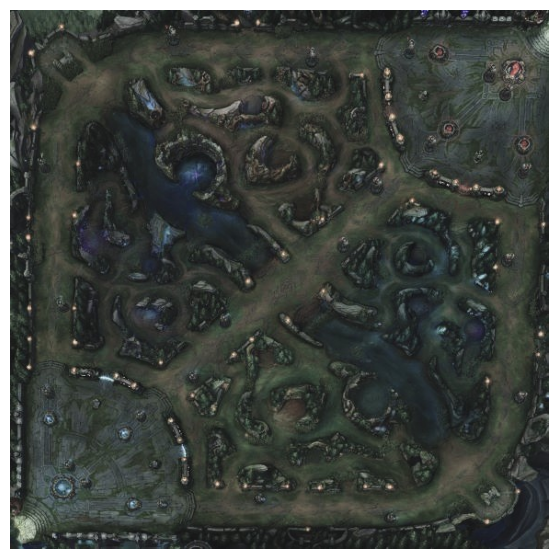

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(0, 15000)
ax.set_ylim(0, 15000)
plt.axis('off')

# Add image of map
map_path = "/content/black_map.jpg"
img = Image.open(map_path)
ax.imshow(img, extent=[0, 15000, 0, 15000])

In [ ]:
# 리스트에 풀고 concat 해서 dataframe으로
death_list = []

for damage_list in wak_death_gang['victimDamageReceived']: # wak_death_gang['victimDamageReceived'] 각행을 루프
    for damage_dict in damage_list: # 각행 안에있는 dict 값들을 루프
        df = pd.json_normalize(damage_dict) # dict 값을 정규화 (json을 푸는)
        death_list.append(df) # 모두 결합

result_df = pd.concat(death_list, ignore_index=True)


In [ ]:
# 내가 갱에 의해 죽은경우 받은 피해량을 확인한다.
# wak_death_gang

death_list = []
if not wak_death_gang.empty:
    for d, ts, id in zip(wak_death_gang['victimDamageReceived'], wak_death_gang['timestamp'],wak_death_gang['matchId']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        death_list.append(df)

    death_damage_log = pd.concat(death_list, axis=0)
    death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])



,matchId,timestamp,name,participantId,spellName,magicDamage,physicalDamage,trueDamage
0,KR_6893477121,17.93075,Samira,9,samirapassive,11,142,0
1,KR_6893477121,17.93075,Samira,9,samirapassive,0,84,0
2,KR_6893477121,17.93075,Samira,9,samirae,43,0,0
3,KR_6893477121,17.93075,Samira,9,samiraq,10,302,0
4,KR_6893477121,17.93075,Samira,9,,0,24,0


In [ ]:
# 매치아이디별 챔피언,포지션 정보 결합
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','participantId','spellName','magicDamage','physicalDamage','trueDamage','totalDamage']
death_damage_log = pd.merge(death_damage_log, champion_info, on=['matchId', 'participantId','championName'], how='inner').drop(['victimId','killerId'],axis=1)
death_damage_log

In [ ]:
# 15분 이전, 어떤 포지션에 의해 가장 많이 죽었을까?
death_before_15 = death_damage_log[death_damage_log['timestamp'] < 15]

In [ ]:
death_before_15

In [ ]:
# 같은 라이너인 MIDDLE 을 제외하면 JUNGLE 의 개입을 많이 받은것을 볼 수 있다.

group_by_position = death_before_15.groupby(['teamPosition']).agg(
    totalDamage = pd.NamedAgg(column = 'totalDamage', aggfunc= 'sum'),
    totalCnt = pd.NamedAgg(column = 'teamPosition',aggfunc = 'count')
    ).reset_index()

group_by_position[['teamPosition','totalDamage','totalCnt']].style.background_gradient(cmap='Blues')

,teamPosition,totalDamage,totalCnt
0,BOTTOM,1515,8
1,JUNGLE,11111,117
2,MIDDLE,22716,183
3,TOP,2364,20
4,UTILITY,2040,24


### 솔로킬을 당한 경우


라인전 전후로 언제 솔로킬을 가장 많이 당했을까?

In [ ]:
wak_death_solo['group'] = 1
wak_death_solo.loc[wak_death_solo['timestamp'] >= 15, 'group'] = 2


<ipython-input-74-db4382886423>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wak_death_solo['group'] = 1


In [ ]:
wak_death_solo['group'].value_counts()

2    51
1    37
Name: group, dtype: int64

damm.. 라인전 이후에 잘리는 경우가 월등히 더많다

* 그렇다면 라인전 이후에는 주로 어디서 잘리는 걸까?

In [ ]:
# 라인을 머문 점수 계산
def calculate_lane(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    blue_zone = [(0,4500,0,4500)]
    red_zone = [(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'top'
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'mid'
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'bottom'
    for range_ in blue_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'blue_zone'
    for range_ in red_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'red_zone'
    return 'jungle' # 나머지는 jungle


In [ ]:
wak_death_solo.loc[:, 'lane'] = wak_death_solo.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)
wak_death_solo

* 좌표를 먼저 시각화해보자
* 아래는 15분 이후 솔로킬로 잘린 경우이다.
> 특히, 바텀라인에서 짤리는 경우가 많은것을 볼 수 있다. 아무래도 라인전(미드) 이후 바텀라인과 스왑하고 사이드를 미는 경우가 많은데, 이 때 표적이 되기 쉽다.

In [ ]:
df = wak_death_solo[wak_death_solo['group'] == 2]

In [ ]:
df['lane'].value_counts()

bottom       20
jungle       13
mid           7
blue_zone     5
top           4
red_zone      2
Name: lane, dtype: int64

In [ ]:
df[['timestamp','position']]

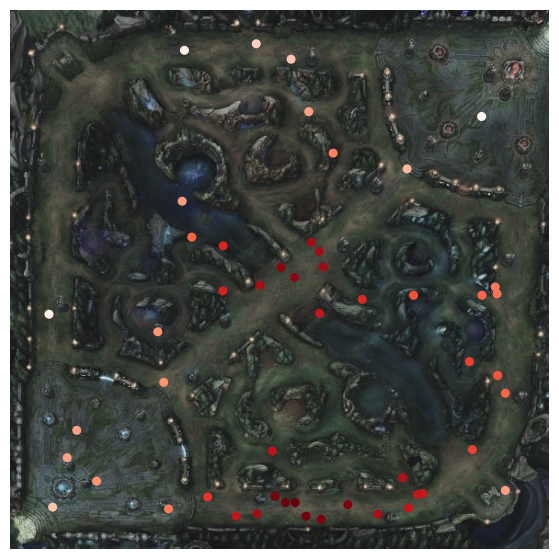

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# 좌표 데이터 추출
x_data = df['position'].apply(lambda pos: pos['x'])
y_data = df['position'].apply(lambda pos: pos['y'])

# 밀도 플롯을 위한 데이터 생성
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(0, 15000)
ax.set_ylim(0, 15000)
plt.axis('off')

# 지도 이미지 추가
map_path = "/content/black_map.jpg"
img = Image.open(map_path)
ax.imshow(img, extent=[0, 15000, 0, 15000])

# 밀도 플롯으로 표시
sc = ax.scatter(x_data, y_data, c=z, cmap='Reds', s=30)


# colorbar 추가
cbar = plt.colorbar(sc)
cbar.set_label('Density')
cbar.remove()

plt.show()


(15분 이후) 미드라이너의 경우 라인전이 끝나고 사이드를 미는 경우가 많다. 해당 summoner 또한 바텀이나 정글지역에서 짤리는 경우가 많은것을 볼 수 있다.

In [ ]:
from PIL import Image, ImageDraw,ImageEnhance

version = '13.24.1'
champion_url = f"http://ddragon.leagueoflegends.com/cdn/{version}/img/profileicon/{iconId}.png"
response = requests.get(champion_url)
img = Image.open(BytesIO(response.content))


mask = Image.new("L", img.size, 0)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0) + img.size, fill=255)
img.putalpha(mask)
# 크기 조절
icon = img.resize((50, 50))

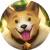

In [ ]:
icon

# 💻 궁금한게 뭘까..?
챔피언별로 봐야할까.. 포지션별로 봐야할까.. 둘다보자! \

우왁굳 vs 여태까지 만난 미드라이너

## ✔️ 해당 summoner에 대한 분석
### ① 여태까지 만난 유저들과의 기본적인 지표비교
* 상대라이너와 비교
* 팀원평균과 비교
* 상대평균과 비교

### ② 왜 죽은 걸가? death 와 관련된 지표
* 라인전 동안 죽은 경우, 가장 개입이 많았던 상대 포지션은 누구일까?
* (솔로킬을 당한경우) 라인전 이후 나는 어디서 짤리는 걸까?

### ③ 왜 진걸까? (부제: 누가 죄인인가 )
* 만약 졌다면 어느라인이 터져서 진걸까?
* 초반과 후반으로 나눠서 분석할 수 있음
* 대표적인 지표로 death 로그와 gold 차이를 분석하면 될것같다
* 중간에 게임을 포기하고 나간 경우도 있음  (이 경우 탈주한 팀원을 만난 횟수를 추가)


> 패배한 경기에서 각 매치별로 15분전후 일어난 데스로그와 그에 따른 골드차이가 어느정도 나타나는지, 그래서 어떤 라인에 의해 게임이 터졌는지 확인해볼 수 있다!

### ④ 현재까지 합이 잘맞는 듀오는 누구일까?
> 합이 잘맞다는 기준을 무엇으로 볼것인가
* 기본적인 지표, 라인전 캐리력, 한타 캐리력, 현재까지의 승률
* summoner 와 상호작용을 통해 가장 많은 kill,assist 성과를 달성한 멤버?

---

## 📊 대시보드 구성

>  ### summoner_INFO
*  summonerICON, summonerName, Rank, 승률, mostChamp,

> ### 패배한 경기 분석
*  누가 죄인인가? 최근 50경기중 패배한 경기를 기준, 15분 전후로 포지션별 골드차이를 시각화
* DEATH position : 라인전 이후 SOLO KILL을 가장 많이 당한 곳 (짤린곳)
*

> ### 듀오 측정기
*


In [ ]:
match_info.head(10)

,teamId,puuid,summonerName,participantId,teamPosition,challenges,summoner1Id,summoner2Id,championName,lane,kills,deaths,assists,totalMinionsKilled,neutralMinionsKilled,goldEarned,goldSpent,champExperience,item0,item1,item2,item3,item4,item5,item6,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,damageDealtToTurrets,damageDealtToBuildings,totalTimeSpentDead,longestTimeSpentLiving,visionScore,win,timePlayed,damageSelfMitigated,totalDamageShieldedOnTeammates,totalHealsOnTeammates,damageDealtToObjectives,soloKills,multikills,abilityUses,damageTakenOnTeamPercentage,skillshotsDodged,skillshotsHit,enemyChampionImmobilizations,laneMinionsFirst10Minutes,controlWardsPlaced,visionScorePerMinute,wardTakedowns,effectiveHealAndShielding,dragonTakedowns,baronTakedowns,teamBaronKills,alliedJungleMonsterKills,enemyJungleMonsterKills,epicMonsterKillsNearEnemyJungler,getTakedownsInAllLanesEarlyJungleAsLaner,jungleCsBefore10Minutes,junglerTakedownsNearDamagedEpicMonster,kda,killsOnOtherLanesEarlyJungleAsLaner,moreEnemyJungleThanOpponent,takedownsBeforeJungleMinionSpawn,junglerKillsEarlyJungle,killsOnLanersEarlyJungleAsJungler,totalCS,matchId,totalCS10Minutes
0,100,fHWB3mif-L5EVhN7LsbfHq2Ydma2E-de-GlwpMGayPCGsX...,dfjkgbkbdfs77,1,TOP,"{'12AssistStreakCount': 0, 'abilityUses': 297,...",14,4,Teemo,JUNGLE,5,12,3,230,31,17239,17100,22882,3089,6653,3020,3118,4646,4645,3340,307794,55452,42341,9350,9350,596,424,23,패배,2908,19076,0,0,21015,4,0,297,0.221925,6,0,0,62,0,0.477476,3,0.000000,0,1,1,2,5,1,0.0,2.00,0,0.666667,0.0,0.0,0,NaN,NaN,261,KR_6897386016,64.00
1,100,SJ45Oocwzn389g6QY2eLcJzzVAtlfAfelvoJtTncr_rA6e...,The Nollan,2,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 426,...",11,4,JarvanIV,JUNGLE,8,6,8,107,176,18139,17250,21262,3161,6333,3071,3156,6610,3111,3364,399873,20357,57342,2103,2103,232,853,42,패배,2908,113202,0,0,51835,1,0,426,0.300549,13,0,25,2,2,0.882718,11,0.000000,2,1,1,62,38,0,NaN,58.15,0,2.666667,NaN,-19.2,0,0.0,1.0,283,KR_6897386016,60.15
2,100,ELaIdl9QqdjENlnKDGbAmYAVxyYAZdcBtIV36Ymwlfkr3W...,메시아빠우왁굳,3,MIDDLE,"{'12AssistStreakCount': 0, 'abilityUses': 505,...",4,14,Zoe,MIDDLE,2,10,5,187,0,12697,11850,18981,6655,4646,3020,4645,2022,1026,3340,182345,28824,29153,3576,3576,339,461,24,패배,2908,9923,0,172,6286,0,0,505,0.152802,4,67,23,41,0,0.499818,1,172.270752,1,0,1,1,0,0,0.0,0.00,0,0.700000,0.0,0.0,0,NaN,NaN,187,KR_6897386016,41.00
3,100,TMRpbFIR4aP_kZVrfDIRY6XRUt9D3xr2vBhSdzpRE_MtK9...,개si발놈들,4,BOTTOM,"{'12AssistStreakCount': 0, 'abilityUses': 354,...",14,4,Lucian,BOTTOM,3,3,3,388,24,20012,25410,21301,6675,3095,3094,6672,3036,3158,3363,431134,27961,30131,4029,4029,142,1734,68,패배,2908,22398,0,0,19397,2,0,354,0.157928,18,24,0,63,4,1.417558,6,0.000000,2,1,1,3,1,0,0.0,0.00,0,2.000000,0.0,0.0,0,NaN,NaN,412,KR_6897386016,63.00
4,100,426gqu0wDVe8ChV4K9yP7T8EIimWAvZ1HJPpH0rqJgIMlw...,빵좀사주세요,5,UTILITY,"{'12AssistStreakCount': 0, 'abilityUses': 152,...",4,7,Brand,BOTTOM,4,7,4,59,0,12522,11875,14810,3871,6653,2421,3020,3118,3165,3364,75525,19392,31823,2069,2069,252,1019,107,패배,2908,11873,0,1016,8407,0,0,152,0.166797,18,6,3,14,9,2.223587,6,1016.000000,1,1,1,0,0,0,0.0,0.00,0,1.142857,0.0,0.0,0,NaN,NaN,59,KR_6897386016,14.00
5,200,y2Re1-BfwCu70OSYBhOe9Oaw9lUKpjgzJJWdPg-p5e1V6O...,영환이사냥꾼,6,TOP,"{'12AssistStreakCount': 1, 'abilityUses': 135,...",6,12,Thresh,TOP,3,2,14,171,0,13165,11925,21858,1029,3068,3075,3111,3110,8020,3340,100886,15997,31551,1375,1375,78,1152,31,승리,2908,56189,1943,0,3067,2,0,135,0.170345,14,21,70,41,1,0.653512,5,1943.592041,1,0,1,0,0,0,0.0,0.00,0,8.500000,0.0,0.0,0,NaN,NaN,171,KR_6897386016,41.00
6,200,4EdsfjfUbFzv7KYbdfgKaWAIQFt0WKT2TopqRkP_yoz_8Q...,요릭조지기과교수,7,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 426,...",11,4,Yorick,JUNGLE,9,4,9,201,167,22190,20183,27434,6610,3748,3078,6665,3181,3071,3364,528217,32875,50986,16716,16716,170,1159,32,승리,2908,46353,0,0,89014,2,1,426,0.275278,19,6,11,1,0,0.662627,14,0.000000,4,1,1,91,0,2,NaN,35.60,1,4.500000,NaN,-45.4,0,0.0,0.0,368,KR_6897386016,36.60
7,200,kLLmc3eLUlo6Ci-GQt

In [ ]:
# 패배한 경기 기준

champion_info = match_info[['matchId','teamId','participantId','summonerName','teamPosition','championName','win']]
# len(champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['teamPosition'] == 'MIDDLE')]) # 미드라이너로 간 경기 42개 (49경기중)
# champion_info

42

In [ ]:
# 매치아이디별 같은팀원들의 victimId 에 해당하는 데이터만 가져온다.
# 각 victimId 에 해당하는 participantId , 포지션, 결합
champion_info['summonerName'] = champion_info.apply(lambda row: row['championName'][:3] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
champion_info.columns=['matchId','teamId','victimId','summonerName','teamPosition','championName','win']


In [ ]:
champion_info

In [ ]:
# 매치아이디별로 본인 팀에 속한 teamId
wak_team = champion_info.loc[(champion_info['summonerName'] == summoner_name), ['matchId','teamId']]

# 왁굳팀만 가져오기
wak_team = pd.merge(wak_team, champion_info, on=['matchId', 'teamId'], how='inner')


In [ ]:
# 패배한 경기는 26경기 (49)
# 패배한 경기의 champion_INFO
wak_team_lose = wak_team[wak_team['win'] == '패배']
wak_team_lose

In [ ]:
# 팀원들의 데스로그
all_death_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'victimId'], how='inner')

In [ ]:
all_death_log.head()

,timestamp,type,position,teamId_x,killerId,victimId,assistingParticipantIds,victimDamageDealt,victimDamageReceived,matchId,teamId_y,summonerName,teamPosition,championName,win
0,2.900233,CHAMPION_KILL,"{'x': 12130, 'y': 2201}",NaN,4.0,10.0,[5],"[{'basic': False, 'magicDamage': 66, 'name': '...","[{'basic': False, 'magicDamage': 175, 'name': ...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
1,7.428850,CHAMPION_KILL,"{'x': 13544, 'y': 3644}",NaN,4.0,10.0,[5],"[{'basic': False, 'magicDamage': 65, 'name': '...","[{'basic': False, 'magicDamage': 278, 'name': ...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
2,15.471183,CHAMPION_KILL,"{'x': 12249, 'y': 2199}",NaN,5.0,10.0,[4],"[{'basic': False, 'magicDamage': 184, 'name': ...","[{'basic': True, 'magicDamage': 0, 'name': 'Mi...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
3,17.561667,CHAMPION_KILL,"{'x': 11230, 'y': 3804}",NaN,2.0,10.0,NaN,NaN,"[{'basic': False, 'magicDamage': 0, 'name': 'K...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배
4,18.573967,CHAMPION_KILL,"{'x': 13539, 'y': 6399}",NaN,3.0,10.0,[5],"[{'basic': False, 'magicDamage': 134, 'name': ...","[{'basic': True, 'magicDamage': 0, 'name': 'Ne...",KR_6884575817,200,무지개반사이응,UTILITY,Lux,패배


In [ ]:
# 팀원들의 데스 로그
position_by_death = all_death_log[all_death_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'}).reset_index()
position_by_death

,teamPosition,type
0,BOTTOM,63
1,JUNGLE,65
2,MIDDLE,59
3,TOP,80
4,UTILITY,65


In [ ]:
# 팀원들의 킬 로그
wak_team_lose.columns = ['matchId',	'teamId',	'killerId','summonerName', 'teamPosition',	'championName',	'win']
all_kill_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'killerId'], how='inner')

position_by_kill = all_kill_log[all_kill_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'})
position_by_kill

,type
teamPosition,
BOTTOM,46
JUNGLE,58
MIDDLE,51
TOP,43
UTILITY,36


In [ ]:
# 데미지로 집계 (받은피해량) - 데스 기준

death_list = []
if not all_death_log.empty:
    for d, ts, id, p in zip(all_death_log['victimDamageReceived'], all_death_log['timestamp'],all_death_log['matchId'],all_death_log['teamPosition']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['teamPosition'] = p
        death_list.append(df)

    death_damage_log = pd.concat(death_list, axis=0)
    death_damage_log = death_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])


death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']

In [ ]:
# 포지션별 15분 이전에 받은 피해량
before_15_death = death_damage_log[death_damage_log['timestamp'] < 15]
damage_by_position = before_15_death.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
damage_by_position['rank'] = damage_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
damage_by_position

In [ ]:
# 데미지로 집계 (가한피해량) - 킬 기준

kill_lists = []
if not all_kill_log.empty:
    for d, ts, id, p in zip(all_kill_log['victimDamageReceived'], all_kill_log['timestamp'],all_kill_log['matchId'],all_kill_log['teamPosition']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['teamPosition'] = p
        kill_lists.append(df)

    kill_damage_log = pd.concat(kill_lists, axis=0)
    kill_damage_log = kill_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    kill_damage_log['name'] = kill_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    kill_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])


kill_damage_log['totalDamage'] = kill_damage_log['magicDamage'] + kill_damage_log['physicalDamage'] + kill_damage_log['trueDamage']

In [ ]:
# 포지션별 15분 이전에 가한 피해량
before_15_kil = kill_damage_log[kill_damage_log['timestamp'] < 15]
kill_by_position = before_15_kil.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
kill_by_position['rank'] = kill_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
kill_by_position

In [ ]:
rank1_counts_kill = kill_by_position[kill_by_position['rank'] == 1].groupby('teamPosition').size()
rank1_counts_damage = damage_by_position[damage_by_position['rank'] == 1].groupby('teamPosition').size()

print(rank1_counts_kill)
print(rank1_counts_damage)

teamPosition
BOTTOM     3
JUNGLE     8
MIDDLE     5
TOP        5
UTILITY    5
dtype: int64
teamPosition
BOTTOM      3
JUNGLE      3
MIDDLE      4
TOP        11
UTILITY     5
dtype: int64


* 패배한 경기 중, 15분이전에 가장 많은 데미지를 받고 죽은 포지션 "TOP"

* 패배한 경기 중, 15분이전에 가장 많은 딜, 킬을한 포지션은 "JUNGLE"

# 경기, 팀별 골드 변화량

>  게임이 어느순간 부터 불리하게 돌아가는지 확인할 수 있는 대표적인 지표로 gold가 있다.  시간별로 gold 격차가 크게 차이나거나, 역전당하는 시점이 있다면 어떤 시점일까?

* 각 matchid, teamid, timestamp 를 groupby 해야함 ✔️

> 대시보드로 어떻게 표현할 것 인가?

* line chart : 본인 + 팀원평균 + 상대팀평균

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
df = pd.concat(match_data_logs)
match_data_log = df[:6]

In [ ]:
# 모든 match 가 concat 된 frames 중 첫번쨰 timestamp data를 가져오면 아래와 같음
log1 = pd.DataFrame(df['info']['frames'][10])
log1

In [ ]:
frames_data = df['info']['frames']
matchId_data= df['metadata']['matchId']

all_data = pd.DataFrame()


# 'frames'의 각 데이터에 대해 반복
for i, frame in enumerate(frames_data):
    # 현재 프레임의 데이터 추출
    frame_data = pd.DataFrame(frame)

    # 현재 프레임의 데이터에 matchId 추가
    frame_data['matchId'] = matchId_data[i]

    # 현재 프레임의 데이터를 기존 데이터프레임에 추가
    all_data = pd.concat([all_data, frame_data])

all_data

In [ ]:
frames_list = pd.DataFrame(all_data['participantFrames'])['participantFrames'].tolist()

In [ ]:
all_data.head(100)

In [ ]:
unique_match_ids = all_data['matchId'].unique()

# 모든 결과를 저장할 리스트 생성
final_result = []

for match_Id in unique_match_ids:
    # match_Id에 해당하는 데이터만 추출
    match_data = all_data[all_data['matchId'] == match_Id]
    timestamp = match_data['timestamp']

    # participantFrames 데이터 처리
    frames_list = pd.DataFrame(match_data['participantFrames'])['participantFrames'].tolist()
    participant_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    moving_data = [[] for _ in range(len(participant_ids))]

    for frame in frames_list:
        for i, participant_id in enumerate(participant_ids):
            if str(participant_id) in frame:
                moving_data[i].append(frame[str(participant_id)])

    moving_dfs = [pd.DataFrame(md) for md in moving_data]
    # moving = pd.concat(moving_dfs, ignore_index=True)

    # 시간 정보 , match_Id 열 추가
    for i, moving_df in enumerate(moving_dfs):
        moving_df['timestamp'] = timestamp / 60000
        moving_df['matchId'] = match_Id

    # 결과를 리스트에 추가
    final_result.extend(moving_dfs)

# 모든 결과를 합쳐서 최종 데이터프레임 생성
final_result_df = pd.concat(final_result, ignore_index=True)


In [ ]:
# GOLD 와 관련된 컬럼
gold = final_result_df[['matchId','timestamp','participantId','position','totalGold','xp','level']]
# gold.head(100)

In [ ]:
gold.head()

In [ ]:
champion_info = champion_info[['matchId','participantId','teamId','teamPosition','summonerName','championName','win']]

In [ ]:
gold_df = pd.merge(gold, champion_info, on=['matchId', 'participantId'], how='inner')
gold_df.head()

,matchId,timestamp,participantId,position,totalGold,xp,level,teamId,teamPosition,summonerName,championName,win
0,KR_6905652615,0.000000,1,"{'x': 554, 'y': 581}",500,0,1,100,TOP,분지울,Warwick,False
1,KR_6905652615,1.000333,1,"{'x': 6874, 'y': 11408}",500,0,1,100,TOP,분지울,Warwick,False
2,KR_6905652615,2.000900,1,"{'x': 1647, 'y': 12285}",563,185,1,100,TOP,분지울,Warwick,False
3,KR_6905652615,3.001167,1,"{'x': 1633, 'y': 12850}",797,671,3,100,TOP,분지울,Warwick,False
4,KR_6905652615,4.001217,1,"{'x': 2261, 'y': 11826}",1088,1284,4,100,TOP,분지울,Warwick,False


* 게임마다 플레이 시간이 다르기 때문에 평균을 내기 애매하다.
* 그래도 15분 이상 게임이니, 확실한건 15분 이전 골드 상황을 비교할 수 있다.

### *idea1. 15분 이전까지 골드차이가 나면 지는 걸까?*

한타도 하기 전에 라인전이 터지면 골드차이가 많이나게 되어 지는경우가 대부분임..

* 우왁굳님이 패배한 경기를 분석해보았습니다. 라인전 동안 '각 라인별' 1분간의 골드변화량을 기준으로 급격하게 골드차이가 난 라인은 어디일까요? 바텀차이일까요?

* 패배한 경기를 기준으로 봐야할까? 이긴 경기는 어떻게?

In [ ]:
lose_match_list = champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['win']== False)]['matchId'].tolist()
lose_match_list

In [ ]:
lose_match_gold = gold_df[gold_df['matchId'].isin(lose_match_list)].groupby(['matchId','timestamp','win','teamPosition']).agg({'totalGold':'sum'}).reset_index()


In [ ]:
lose_match_gold['timestamp'] = lose_match_gold['timestamp'].astype(int)

In [ ]:
# (15분, 라인전 동안) 포지션별 골드차이
line_lose = lose_match_gold[(lose_match_gold['timestamp'] >= 0) & (lose_match_gold['timestamp'] < 16)].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
line_lose['totalGold_diff'] = line_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()

#(경기가 끝나고)포지션별 골드차이
hanta_lose = lose_match_gold[lose_match_gold['timestamp'] >= 15].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
hanta_lose['totalGold_diff'] = hanta_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()
hanta_lose = hanta_lose.groupby('matchId').tail(5)

# line_lose[line_lose['win'] == False]

In [ ]:
# (이긴팀-진팀) 값이 - 일수록 차이가 많이난 포지션이다.
# line_lose_gold = line_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(누적)
line_lose['rank'] = line_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')

# hanta_lose_gold = hanta_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(누적)
hanta_lose['rank'] = hanta_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')


hanta_lose[hanta_lose['totalGold_diff'] < -2000]['teamPosition'].value_counts()

Series([], Name: teamPosition, dtype: int64)

In [ ]:
# most_common_ranks = t.groupby('teamPosition')['rank'].apply(lambda x: x.mode()[0]).reset_index()

# 라인전,한타 포지션별 평균 골드차이
avg_gold_by_position_line = line_lose.groupby(['teamPosition','timestamp'])['totalGold_diff'].mean().reset_index()
avg_gold_by_position_hanta = hanta_lose.groupby('teamPosition')['totalGold_diff'].mean().reset_index()

# 미드차이가 났지만 진 겯기
hanta_lose[(hanta_lose['teamPosition'] == 'MIDDLE')&(hanta_lose['totalGold_diff']>0)] #['totalGold_diff'].mean()

In [ ]:
avg_gold_by_position_line

In [ ]:
df = avg_gold_by_position_line[avg_gold_by_position_line['teamPosition'] != '']
df['totalGold_diff'] = df['totalGold_diff'].astype(int)

result = []
for team in df['teamPosition'].unique():
    team_data = {
        'id': team,
        'data': []
    }

    team_df = df[df['teamPosition'] == team]
    for index, row in team_df.iterrows():
        item = {
            'x': row["timestamp"],
            'y': row["totalGold_diff"]
        }
        team_data["data"].append(item)

    result.append(team_data)

result